## Credit Scoring Model

<!-- TABLE OF CONTENTS -->
<details>
  <summary>Table of Contents</summary>
  <ol>
    <li><a href="#import-dependencies">Import Dependencies</a></li>
    <li><a href="#load-data">Load Data</a></li>
    <li><a href="#quick-scan">Quick Scan</a></li>
    <li><a href="#data-split">Data Split</a></li>
    <li><a href="#data-formatting">Data formatting</a></li>
    <li><a href="#variable-selection">Variable Selection</a>
      <ul>
        <li><a href="#data-quality">Data Quality</a></li>
        <li><a href="#information-value-and-woe">Information Value and WoE</a></li>
        <li><a href="#trend">Trend</a></li>
        <li><a href="#correlation">Correlation</a></li>
      </ul>
    </li>
    <li><a href="#performance-testing">Performance Testing</a></li>
  </ol>
</details>


### Import dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from scorecard.information_value import add_infinity_boundaries, numeric_get_optimal_bins, \
                                         get_all_IVs, get_WoE_encodings, encode_WoE
from scorecard.visuals import plot_evaluation, plot_all_IV, plot_correlation_matrix, \
                              plot_C_vs_num_features, plot_multiple_WoE_IV, plot_feature_coeffs
                              
from scorecard.utils import IQR_outlier_detection, get_C_versus_n_features

pd.set_option("display.max_rows", 25)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 10000)

### Load Data

In [2]:
# Load data
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

### Quick Scan

In [3]:
# Shape of dataset
print("Dataframe shape : ", df.shape)

# Show 5 first rows
df.head(2)

Dataframe shape :  (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [4]:
# Summary of data
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# Get all unique categorical values
df.select_dtypes(include="object").apply(lambda col: col.unique()) # use .to_list() if elements are truncated while printing

customerID          [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
gender                                                 [Female, Male]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
PhoneService                                                [No, Yes]
MultipleLines                             [No phone service, No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                         [No, Yes, No internet service]
OnlineBackup                           [Yes, No, No internet service]
DeviceProtection                       [No, Yes, No internet service]
TechSupport                            [No, Yes, No internet service]
StreamingTV                            [No, Yes, No internet service]
StreamingMovies                        [No, Yes, No internet service]
Contract                         [Month-to-month, One year, Two year]
PaperlessBilling    

### Data formatting

In [6]:
# Using dictionary to convert specific columns
# convert_dict = {"A": int,
#                 "C": float
#                }
# df = df.astype(convert_dict)

In [7]:
# Some formatting 

df = df.drop(columns=["customerID"])

df["Label"] = df["Churn"].map({"Yes": 1, "No": 0})
df["SeniorCitizen"] = df["SeniorCitizen"].map({0: "No", 1: "Yes"})

df = df.drop(columns=["Churn"])

df["TotalCharges"] = df["TotalCharges"].replace(" ",0)
df["TotalCharges"] = df["TotalCharges"].astype(float)

#### Data split

In [8]:
# Train-Test split first to prevent data-leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

#### Exploratory Data Analysis

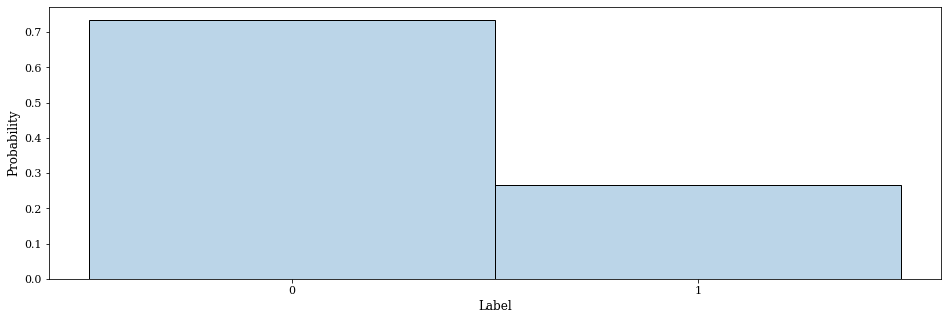

In [9]:
sns.histplot(x=train_df["Label"].astype(str), stat="probability", alpha=0.3)
plt.show()

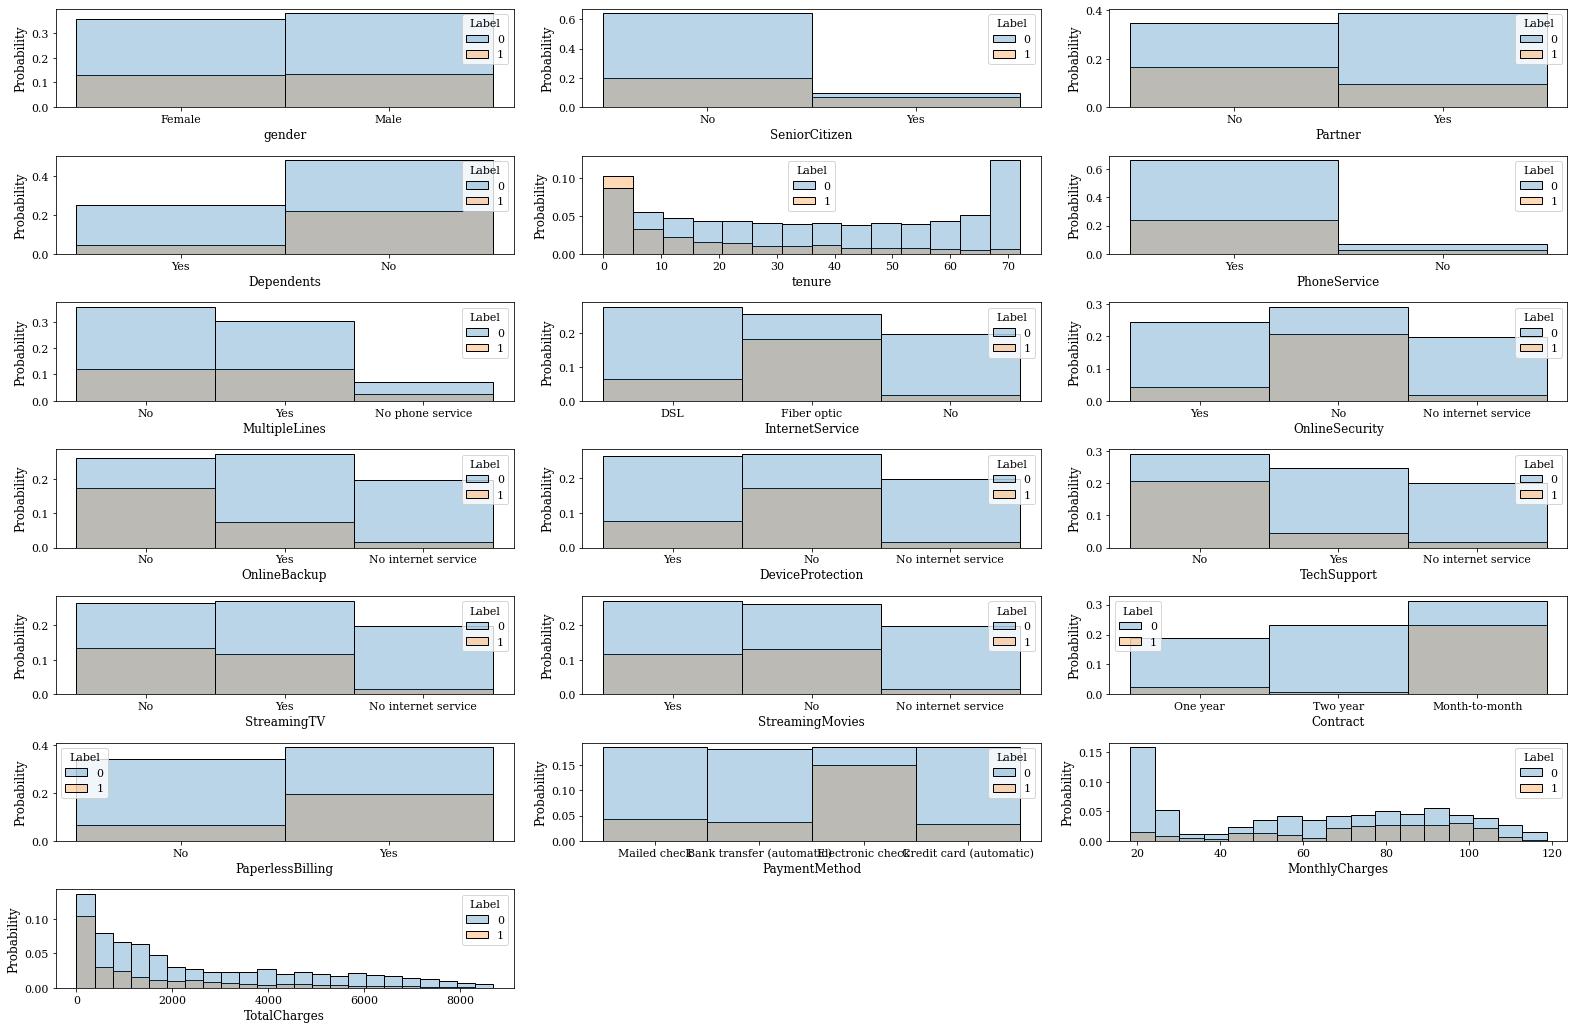

In [10]:
n_cols, n_rows = 3, 8

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22, 2*n_rows))
axs = axs.flatten()

for i, col in enumerate(train_df.drop(columns="Label")):
    sns.histplot(x=col, hue="Label", data=train_df, ax=axs[i], stat="probability", alpha=0.3)
for ax in axs[i+1:]:
    ax.set_visible(False) # To remove unused plots
plt.tight_layout()

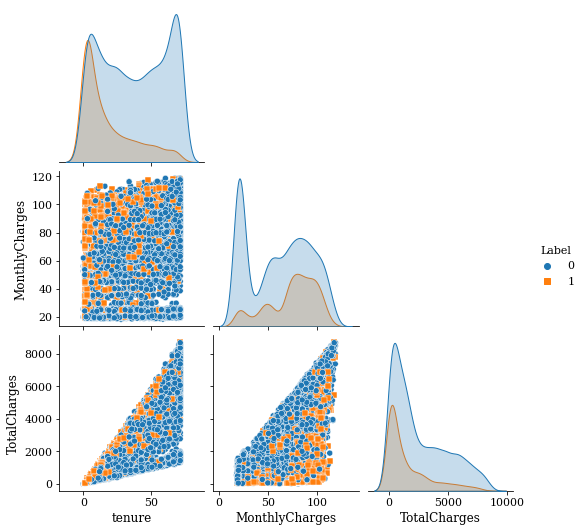

In [11]:
# Data analysis
sns.pairplot(df, hue='Label', corner=True, markers=["o", "s"])
plt.show()

### Variable Selection

#### Data Quality

##### Outliers

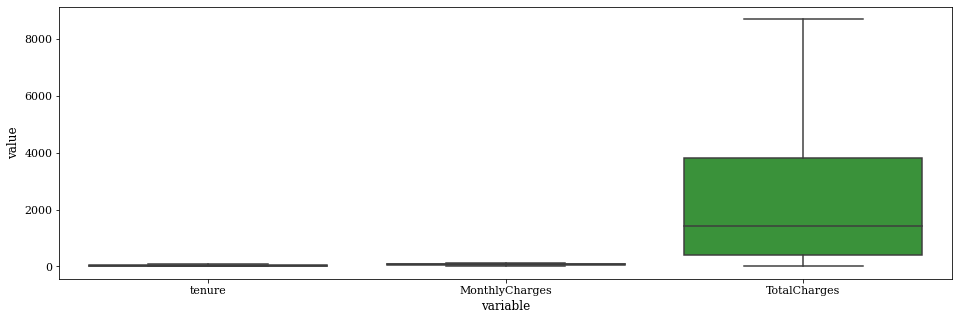

                 count         mean          std    min      25%       50%        75%     max
tenure          5634.0    32.373092    24.424539   0.00    9.000    29.000    55.0000    72.0
MonthlyCharges  5634.0    64.864253    30.089324  18.25   35.750    70.525    89.9375   118.6
TotalCharges    5634.0  2287.087948  2263.197899   0.00  406.275  1405.650  3806.6125  8684.8


In [12]:
cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Plot boxplot of numeric columns
sns.boxplot(x="variable", y="value", data=train_df[cols].melt())
plt.show()

# Summary of data
print(train_df[cols].describe().T)

In [13]:
# Indicate whether an element from each passed column is an outlier according to IQR method
outlier_mask = train_df[cols].apply(IQR_outlier_detection, axis=0)
print(f"Number of outliers per column:\n{outlier_mask.sum(axis=0).to_string()}\n")

# Print rows containing outliers
print("Rows with outliers:")
train_df.loc[(outlier_mask).any(axis=1),cols]

Number of outliers per column:
tenure            0
MonthlyCharges    0
TotalCharges      0

Rows with outliers:


,tenure,MonthlyCharges,TotalCharges


In [14]:
# Remove outlier rows via IQR Mask
train_df = train_df[~(outlier_mask).any(axis=1)]

# If need be, code to manually remove rows based on specific criteria
# col = ...
# train_df = train_df.drop(train_df[train_df[col] < 50].index)

In [15]:
# Summary of data after removed outliers
train_df[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5634.0,32.373092,24.424539,0.00,9.000,29.000,55.0000,72.0
MonthlyCharges,5634.0,64.864253,30.089324,18.25,35.750,70.525,89.9375,118.6
TotalCharges,5634.0,2287.087948,2263.197899,0.00,406.275,1405.650,3806.6125,8684.8


##### Missing Values

In [16]:
print(train_df.isnull().mean().round(4).mul(100).sort_values(ascending=False))

gender              0.0
SeniorCitizen       0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
tenure              0.0
Dependents          0.0
Partner             0.0
Label               0.0
dtype: float64


In [17]:
# Manually pass columns and their imputation value
cols = []
impute_value = "Missing value" # df[cols].median()) # df[cols].mean()) # df[cols].mode()

In [18]:
train_df[cols] = train_df[cols].fillna(impute_value)

##### Low Variance Filter


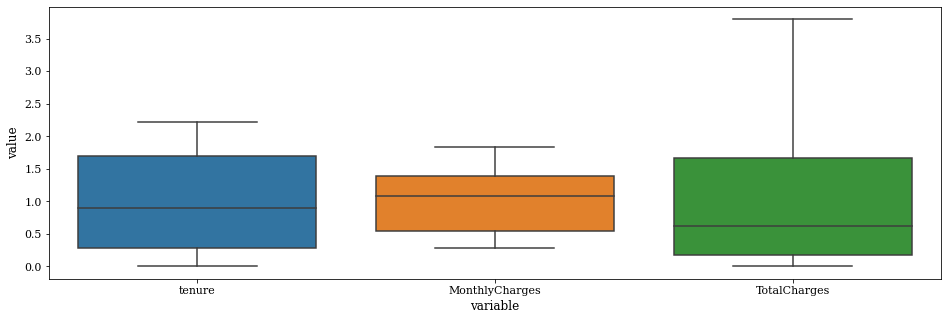

In [19]:
cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Normalize columns to similar scales by dividing by the mean
temp_df = train_df[cols].divide(train_df[cols].mean())

# Plot boxplot of numeric columns
sns.boxplot(x="variable", y="value", data=temp_df.melt())
plt.show()

In [20]:
# Check for low-variance columns
threshold = 0.005
variances = temp_df.var()
var_mask = variances > threshold

print(f"Variances:\n{variances.to_string()}\n")
print(f"Feature below threshold: {(~var_mask).sum()}")

Variances:
tenure            0.569226
MonthlyCharges    0.215186
TotalCharges      0.979218

Feature below threshold: 0


In [21]:
# Manually remove columns with low variance
cols = train_df[cols].columns[~var_mask]
print(f"Dropping the following columns: {cols}")

train_df = train_df.drop(columns=cols)

Dropping the following columns: Index([], dtype='object')


#### Information Value and WoE

In [22]:
# Discretize continous features via binning
cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# save used bins for test set transformation later
numerical_bins = {}

for i, col in enumerate(cols):
    bins = numeric_get_optimal_bins(train_df, col)
    bins = add_infinity_boundaries(bins)
    train_df[col+"Binned"] = pd.cut(train_df[col], bins)
    numerical_bins[col] = bins

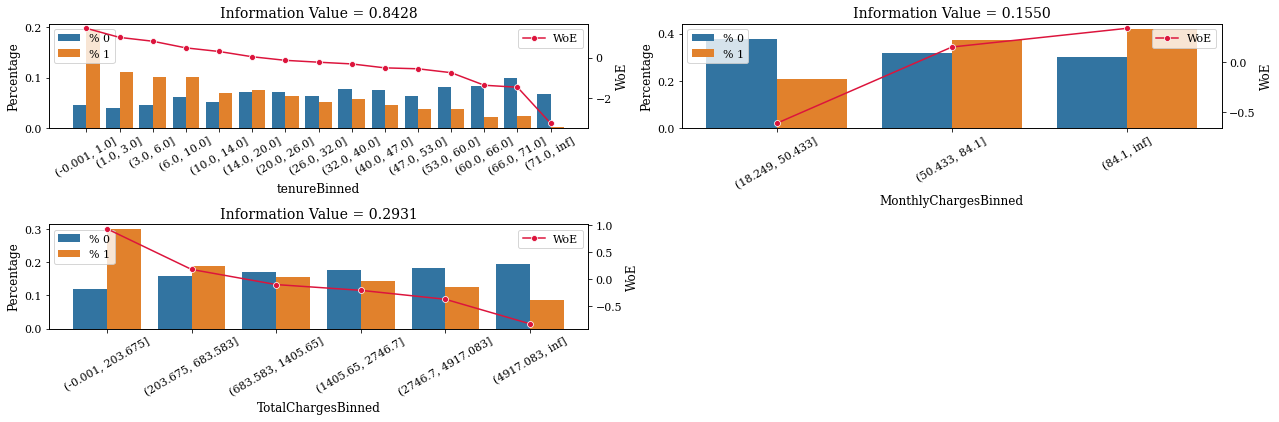

In [23]:
# Plot the resulting bins
cols = [col+"Binned" for col in cols]
plot_multiple_WoE_IV(train_df, cols)

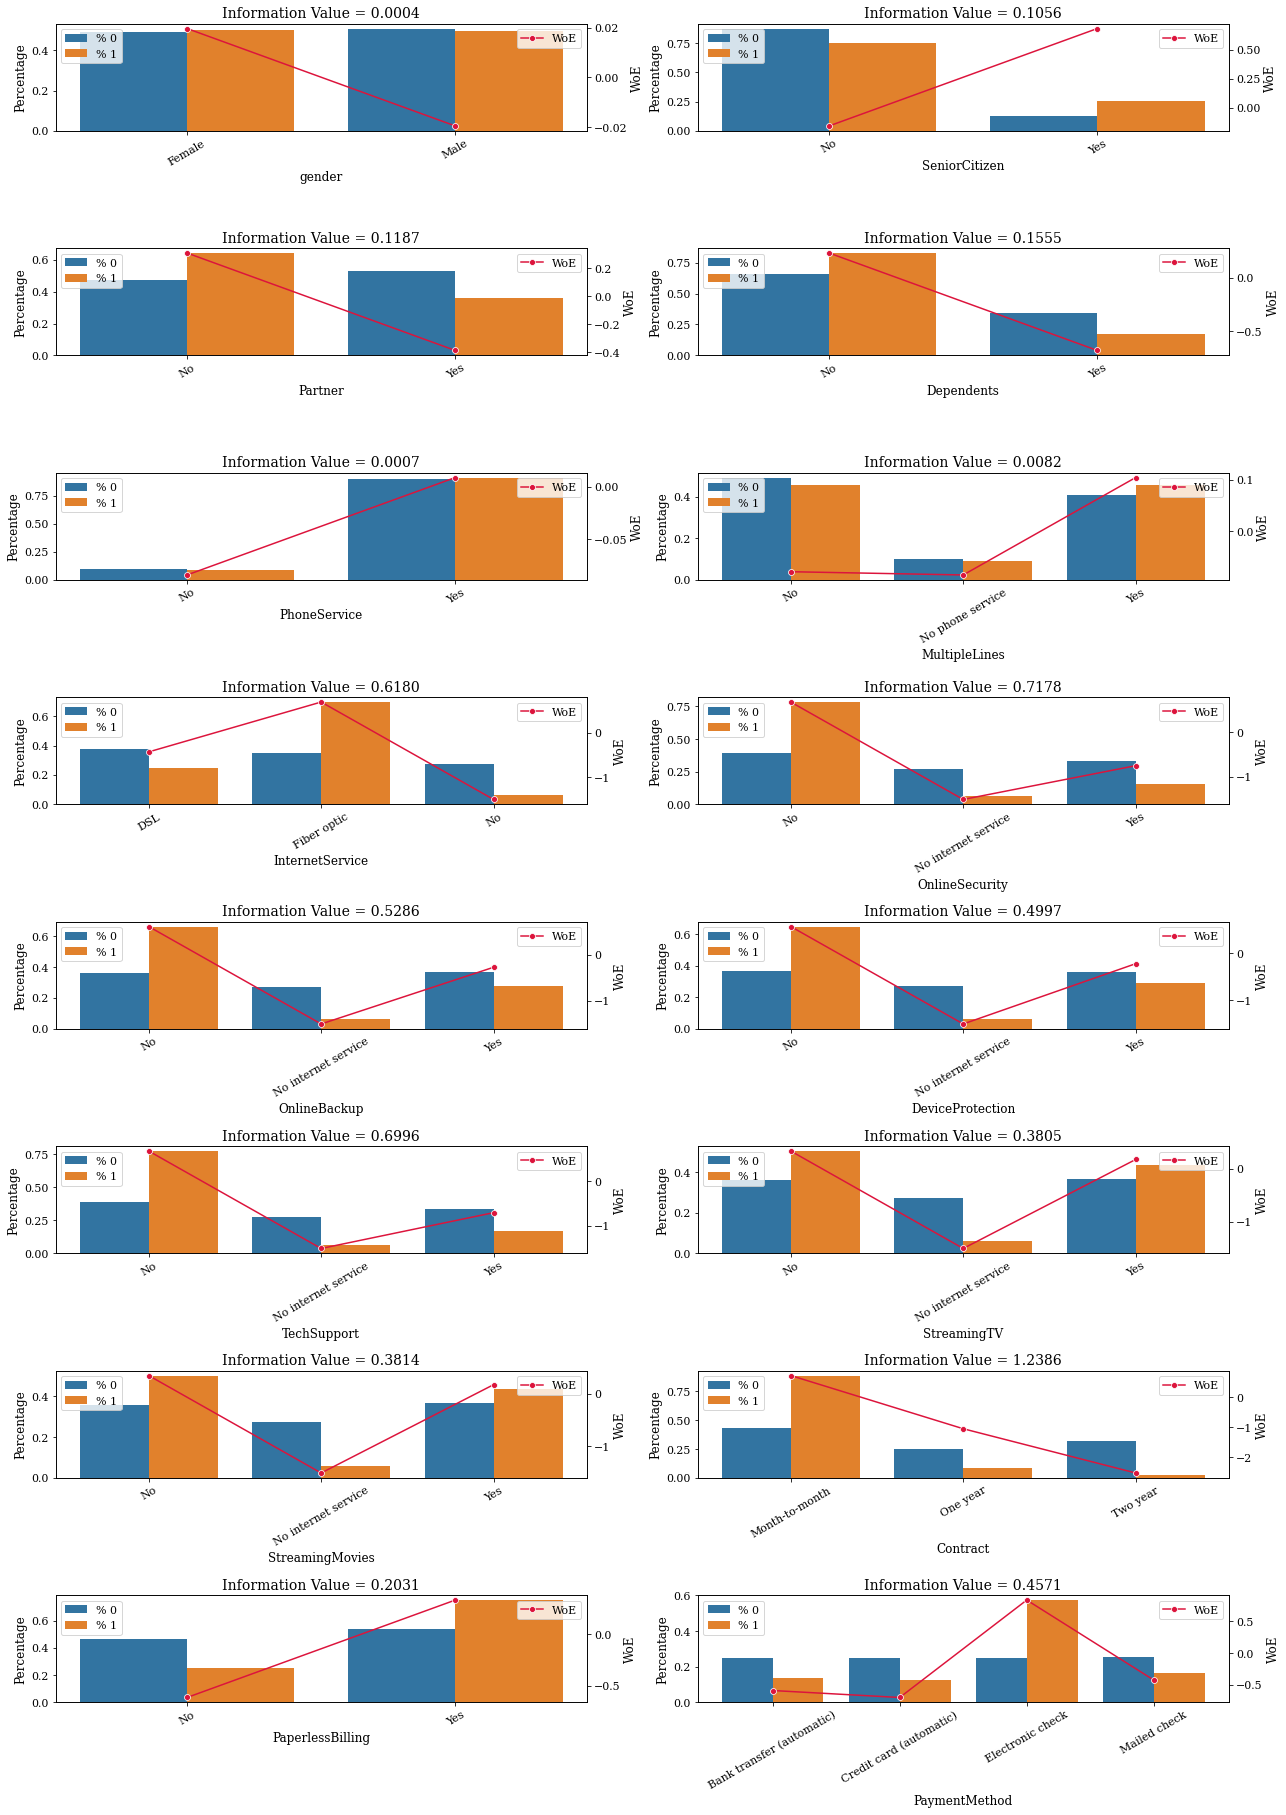

In [24]:
cols = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", 
        "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
        "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]
plot_multiple_WoE_IV(df, cols)


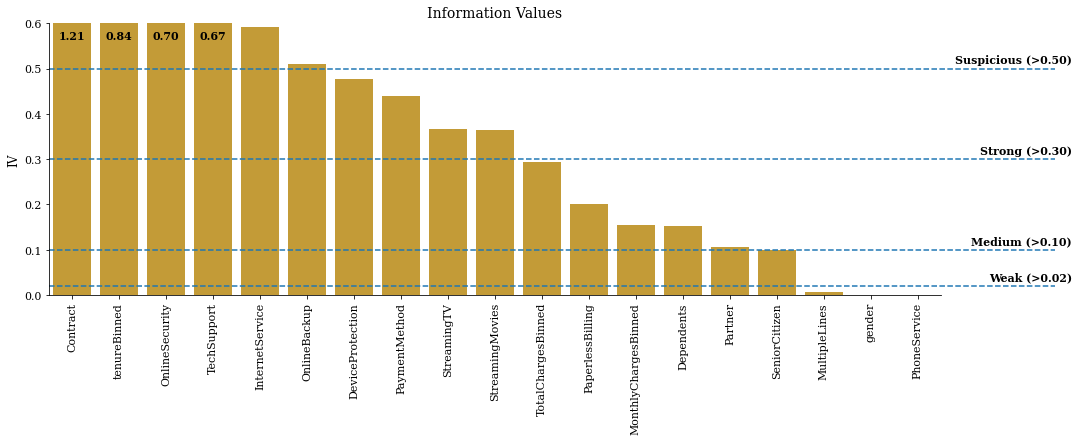

In [25]:
cols = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", 
        "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
        "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", 
        "tenureBinned", "MonthlyChargesBinned", "TotalChargesBinned"]

iv_df = get_all_IVs(train_df, cols)
plot_all_IV(iv_df)

In [26]:
# Select columns with sufficient IV
iv_threshold = 0.05
cols = iv_df[iv_df.values > iv_threshold].index.values

In [27]:
# Get WoE encoding of chosen features and drop other features
WoE_encodings = get_WoE_encodings(train_df, cols)
train_df = encode_WoE(train_df, WoE_encodings, drop_other=True)

In [28]:
train_df.head(5)

,ContractWoE,tenureBinnedWoE,OnlineSecurityWoE,TechSupportWoE,InternetServiceWoE,OnlineBackupWoE,DeviceProtectionWoE,PaymentMethodWoE,StreamingTVWoE,StreamingMoviesWoE,TotalChargesBinnedWoE,PaperlessBillingWoE,MonthlyChargesBinnedWoE,DependentsWoE,PartnerWoE,SeniorCitizenWoE,Label
2142,-0.994217,-0.122867,-0.754197,0.667787,-0.420607,0.606503,-0.208906,-0.430465,0.333635,0.176398,-0.096876,-0.610321,0.151570,-0.673354,0.293115,-0.151238,0
1623,-2.515885,-0.733280,0.678261,0.667787,0.676383,-0.268577,0.560452,-0.536821,0.165093,0.176398,-0.819804,0.335977,0.338636,0.228150,0.293115,-0.151238,0
6074,0.721405,1.460753,0.678261,0.667787,-0.420607,0.606503,0.560452,0.816426,0.333635,0.324271,0.930035,0.335977,-0.611313,0.228150,-0.364304,-0.151238,1
1362,0.721405,0.822109,0.678261,0.667787,0.676383,0.606503,0.560452,0.816426,0.333635,0.324271,0.181757,0.335977,0.151570,0.228150,0.293115,-0.151238,1
6754,-2.515885,1.460753,-0.754197,-0.694968,-0.420607,-0.268577,0.560452,-0.536821,0.333635,0.324271,0.930035,0.335977,0.151570,-0.673354,0.293115,-0.151238,0


#### Trend

In [29]:
# trend

#### Correlation

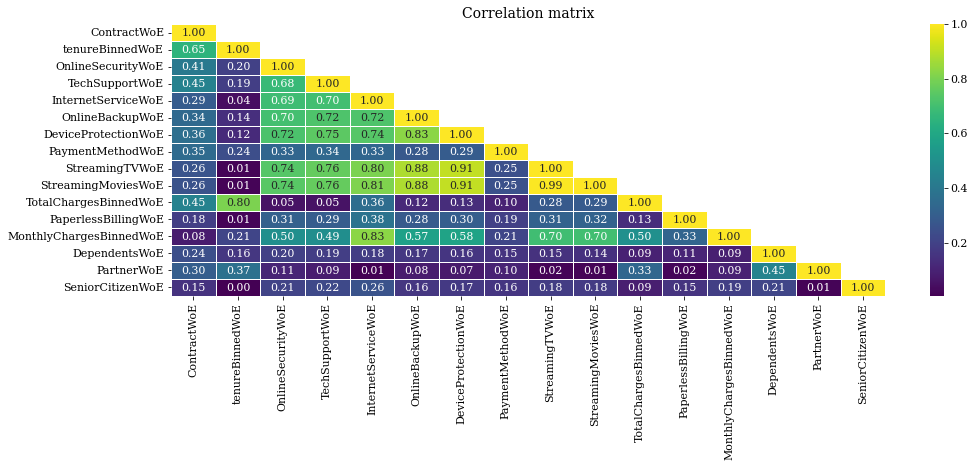

In [30]:
plot_correlation_matrix(train_df.drop(columns='Label'))

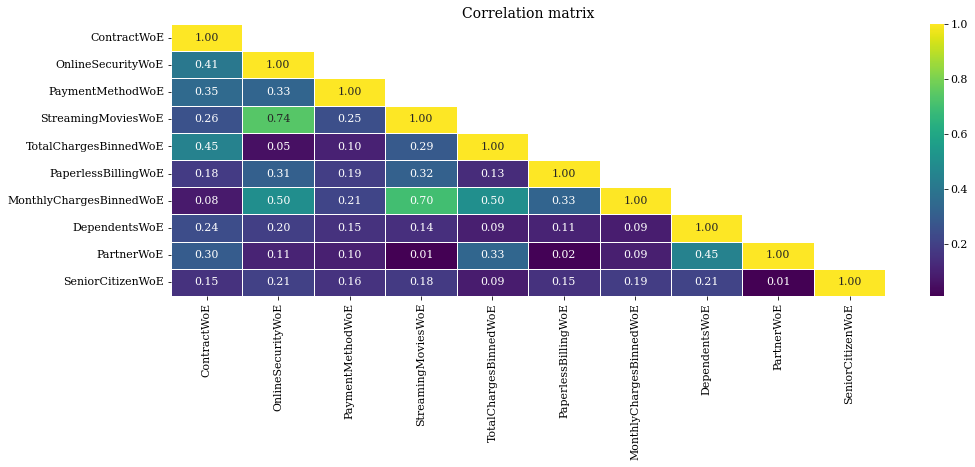

In [31]:
# Manually select set of features to drop
cols = ["TechSupportWoE", "InternetServiceWoE", "OnlineBackupWoE", "DeviceProtectionWoE", "StreamingTVWoE", "tenureBinnedWoE"]
plot_correlation_matrix(train_df.drop(columns=[*cols, "Label"]))

In [32]:
# Drop the selected cols
train_df = train_df.drop(columns=cols)

#### Penalised regression

In [33]:
# Split training data in features and labels
train_x = train_df.drop(columns="Label")
train_y = train_df["Label"]

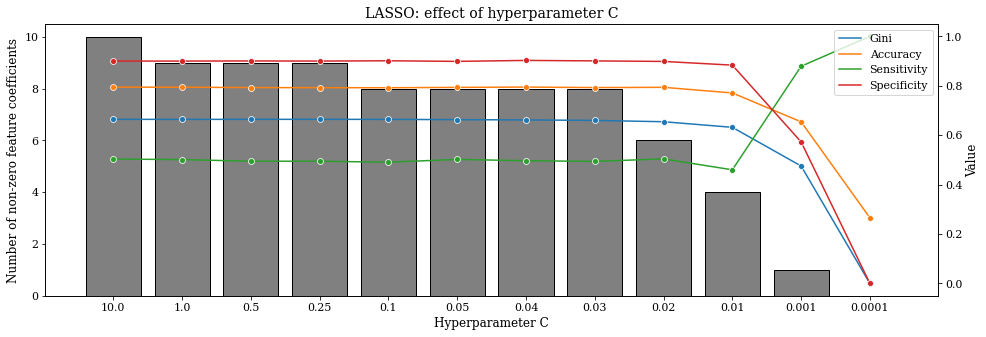

In [34]:
result_df = get_C_versus_n_features(train_x, train_y)
# Plot the results
fig, ax = plt.subplots()
plot_C_vs_num_features(result_df, ax)

In [35]:
# Manually select hyperparameter c based on plot
c = 0.02

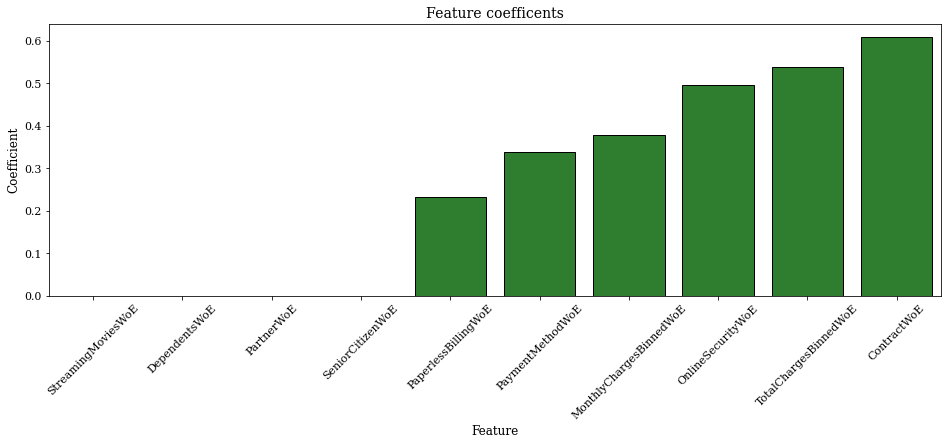

In [36]:
model = LogisticRegression(penalty="l1", C=c, solver="liblinear")
model.fit(train_x, train_y)


coefficients = model.coef_.ravel()
features = train_x.columns
plot_feature_coeffs(features, coefficients)


In [37]:
# Select final features based on LASSO penalized regression model
selected_features = train_x.columns[model.coef_.ravel() != 0]

train_x = train_x[selected_features]
train_x.head(5)

,ContractWoE,OnlineSecurityWoE,PaymentMethodWoE,TotalChargesBinnedWoE,PaperlessBillingWoE,MonthlyChargesBinnedWoE
2142,-0.994217,-0.754197,-0.430465,-0.096876,-0.610321,0.151570
1623,-2.515885,0.678261,-0.536821,-0.819804,0.335977,0.338636
6074,0.721405,0.678261,0.816426,0.930035,0.335977,-0.611313
1362,0.721405,0.678261,0.816426,0.181757,0.335977,0.151570
6754,-2.515885,-0.754197,-0.536821,0.930035,0.335977,0.151570


### Performance testing

In [38]:
# Preprocess test data
for col in numerical_bins.keys():
    test_df[col+"Binned"] = pd.cut(test_df[col], numerical_bins[col])
test_df = encode_WoE(test_df, WoE_encodings, drop_other=False)

In [39]:
# Check missing
print(test_df.isnull().mean().round(4).mul(100).sort_values(ascending=False))

gender                 0.0
DeviceProtectionWoE    0.0
TotalChargesBinned     0.0
ContractWoE            0.0
tenureBinnedWoE        0.0
                      ... 
Contract               0.0
PaperlessBilling       0.0
PaymentMethod          0.0
MonthlyCharges         0.0
SeniorCitizenWoE       0.0
Length: 39, dtype: float64


In [40]:
# Split testing data in features and labels
test_x = test_df[selected_features]
test_y = test_df["Label"]

In [41]:
print(f"Train shape\n - X: {train_x.shape}\n - y: {train_y.shape}")
print(f"Test shape\n - X: {test_x.shape}\n - y: {test_y.shape}")

Train shape
 - X: (5634, 6)
 - y: (5634,)
Test shape
 - X: (1409, 6)
 - y: (1409,)


In [42]:
# Instantiate and fit regression model with 
model = LogisticRegression(penalty="l1", C=c, solver="liblinear")
model.fit(train_x, train_y)

LogisticRegression(C=0.02, penalty='l1', solver='liblinear')

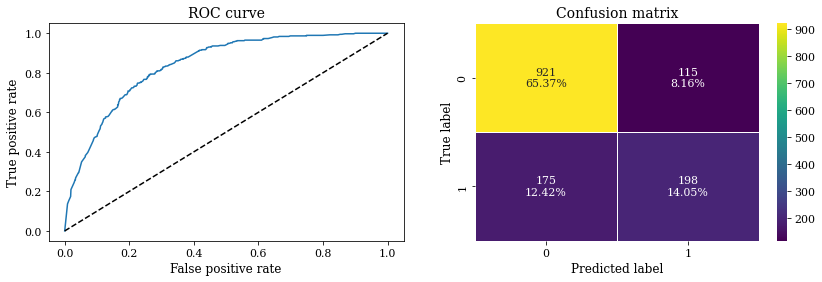

Gini Coefficient:0.6790

Accuracy	:0.7942
Sensitivity	:0.5308
Specificity	:0.8890


In [43]:
# Get estimates
proba_y = model.predict_proba(test_x)

# Depending on risk aversion level of client, we can change the default treshold of 0.5 based on results on train (/or ideally validation) data
plot_evaluation(test_y, proba_y, threshold=0.5)

In [45]:
log_odds = model.coef_[0]
pd.DataFrame(log_odds, 
             test_x.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
ContractWoE,0.609237
TotalChargesBinnedWoE,0.537712
OnlineSecurityWoE,0.495008
MonthlyChargesBinnedWoE,0.379064
PaymentMethodWoE,0.338632
PaperlessBillingWoE,0.232623


In [48]:
odds = np.exp(model.coef_[0])
pd.DataFrame(odds, 
             test_x.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
ContractWoE,1.839028
TotalChargesBinnedWoE,1.712086
OnlineSecurityWoE,1.640511
MonthlyChargesBinnedWoE,1.460916
PaymentMethodWoE,1.403027
PaperlessBillingWoE,1.261905


“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”
https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1